In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import cv2

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

np.random.seed(42)


In [2]:
DATA_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\raw\lfw\lfw-deepfunneled\lfw-deepfunneled")
RESULTS_DIR = Path(r"C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\results\face_exploration")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"LFW directory: {DATA_DIR}")
print(f"Results will be saved to: {RESULTS_DIR}")
print(f"\nDataset exists: {DATA_DIR.exists()}")


LFW directory: C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\data\raw\lfw\lfw-deepfunneled\lfw-deepfunneled
Results will be saved to: C:\Users\MSI GF66\OneDrive - National Polyechnic University of Armenia\Desktop\Emotion_recognition\results\face_exploration

Dataset exists: True


## Dataset Structure and Statistics

In [3]:
def analyze_lfw_structure(data_dir):
    person_image_counts = {}
    total_images = 0

    for person_name in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person_name)
        if os.path.isdir(person_path):
            images = [f for f in os.listdir(person_path) if f.endswith(('.jpg', '.png'))]
            count = len(images)
            person_image_counts[person_name] = count
            total_images += count

    return person_image_counts, total_images

print("Analyzing dataset structure...")
person_counts, total_images = analyze_lfw_structure(DATA_DIR)

print(f"\n=== LFW DATASET STATISTICS ===")
print(f"Total number of people: {len(person_counts)}")
print(f"Total number of images: {total_images}")
print(f"Average images per person: {total_images/len(person_counts):.2f}")
print(f"\nMax images for one person: {max(person_counts.values())}")
print(f"Min images for one person: {min(person_counts.values())}")

counts_array = np.array(list(person_counts.values()))
print(f"\nMedian images per person: {np.median(counts_array):.0f}")
print(f"Std deviation: {np.std(counts_array):.2f}")


Analyzing dataset structure...

=== LFW DATASET STATISTICS ===
Total number of people: 5749
Total number of images: 13233
Average images per person: 2.30

Max images for one person: 530
Min images for one person: 1

Median images per person: 1
Std deviation: 9.02


## Class Imbalance Analysis

In [4]:
counts_distribution = Counter(person_counts.values())

print("=== IMAGES PER PERSON DISTRIBUTION ===")
print(f"People with 1 image: {counts_distribution[1]}")
print(f"People with 2-5 images: {sum(counts_distribution[i] for i in range(2,6))}")
print(f"People with 6-10 images: {sum(counts_distribution[i] for i in range(6,11))}")
print(f"People with 11-20 images: {sum(counts_distribution[i] for i in range(11,21))}")
print(f"People with 20+ images: {sum(counts_distribution[i] for i in range(21, max(counts_distribution.keys())+1))}")

top_people = sorted(person_counts.items(), key=lambda x: x[1], reverse=True)[:10]
print("\n=== TOP 10 PEOPLE (Most Images) ===")
for i, (name, count) in enumerate(top_people, 1):
    print(f"{i:2d}. {name:30s}: {count:3d} images")


=== IMAGES PER PERSON DISTRIBUTION ===
People with 1 image: 4069
People with 2-5 images: 1369
People with 6-10 images: 168
People with 11-20 images: 86
People with 20+ images: 57

=== TOP 10 PEOPLE (Most Images) ===
 1. George_W_Bush                 : 530 images
 2. Colin_Powell                  : 236 images
 3. Tony_Blair                    : 144 images
 4. Donald_Rumsfeld               : 121 images
 5. Gerhard_Schroeder             : 109 images
 6. Ariel_Sharon                  :  77 images
 7. Hugo_Chavez                   :  71 images
 8. Junichiro_Koizumi             :  60 images
 9. Jean_Chretien                 :  55 images
10. John_Ashcroft                 :  53 images


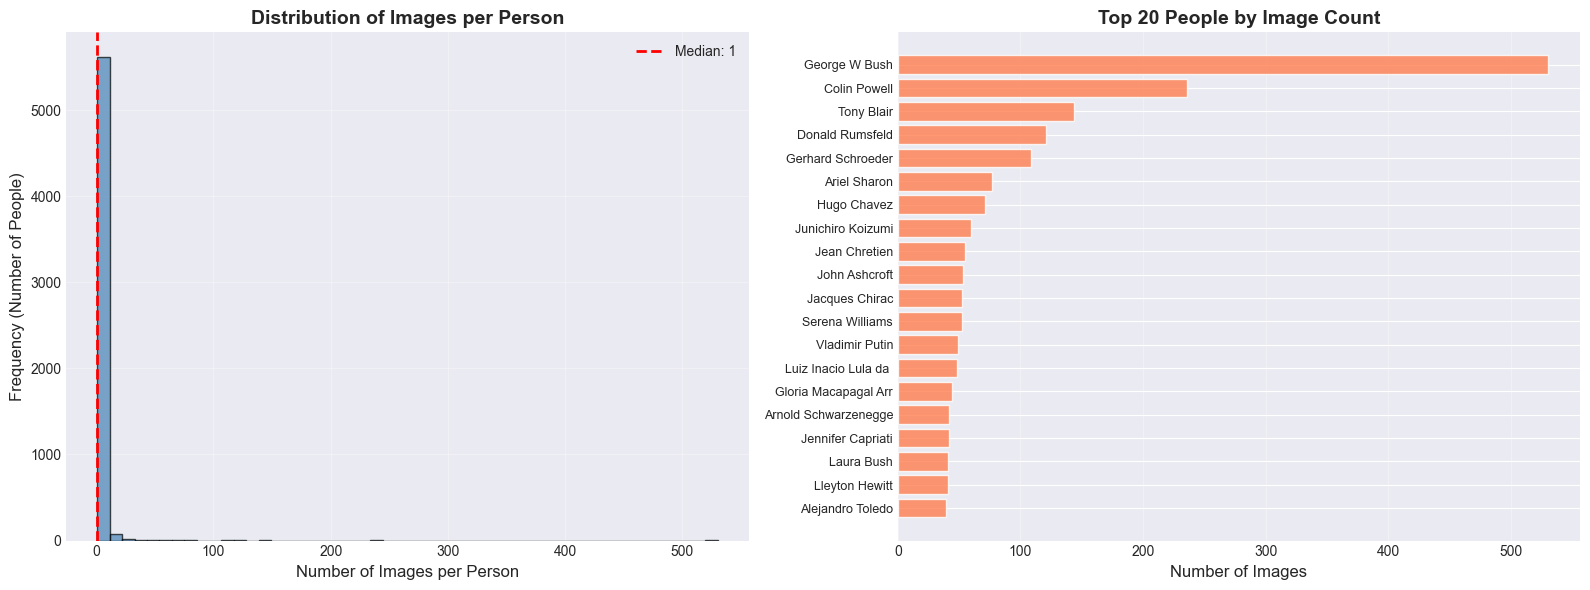

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

counts_list = list(person_counts.values())
axes[0].hist(counts_list, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Number of Images per Person', fontsize=12)
axes[0].set_ylabel('Frequency (Number of People)', fontsize=12)
axes[0].set_title('Distribution of Images per Person', fontsize=14, fontweight='bold')
axes[0].axvline(np.median(counts_list), color='red', linestyle='--', linewidth=2, label=f'Median: {np.median(counts_list):.0f}')
axes[0].legend()
axes[0].grid(alpha=0.3)

top_20 = sorted(person_counts.items(), key=lambda x: x[1], reverse=True)[:20]
names, counts = zip(*top_20)
names_short = [n.replace('_', ' ')[:20] for n in names]

axes[1].barh(range(len(names_short)), counts, color='coral', alpha=0.8)
axes[1].set_yticks(range(len(names_short)))
axes[1].set_yticklabels(names_short, fontsize=9)
axes[1].set_xlabel('Number of Images', fontsize=12)
axes[1].set_title('Top 20 People by Image Count', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()



## Sample Images Visualization

Loading sample faces...


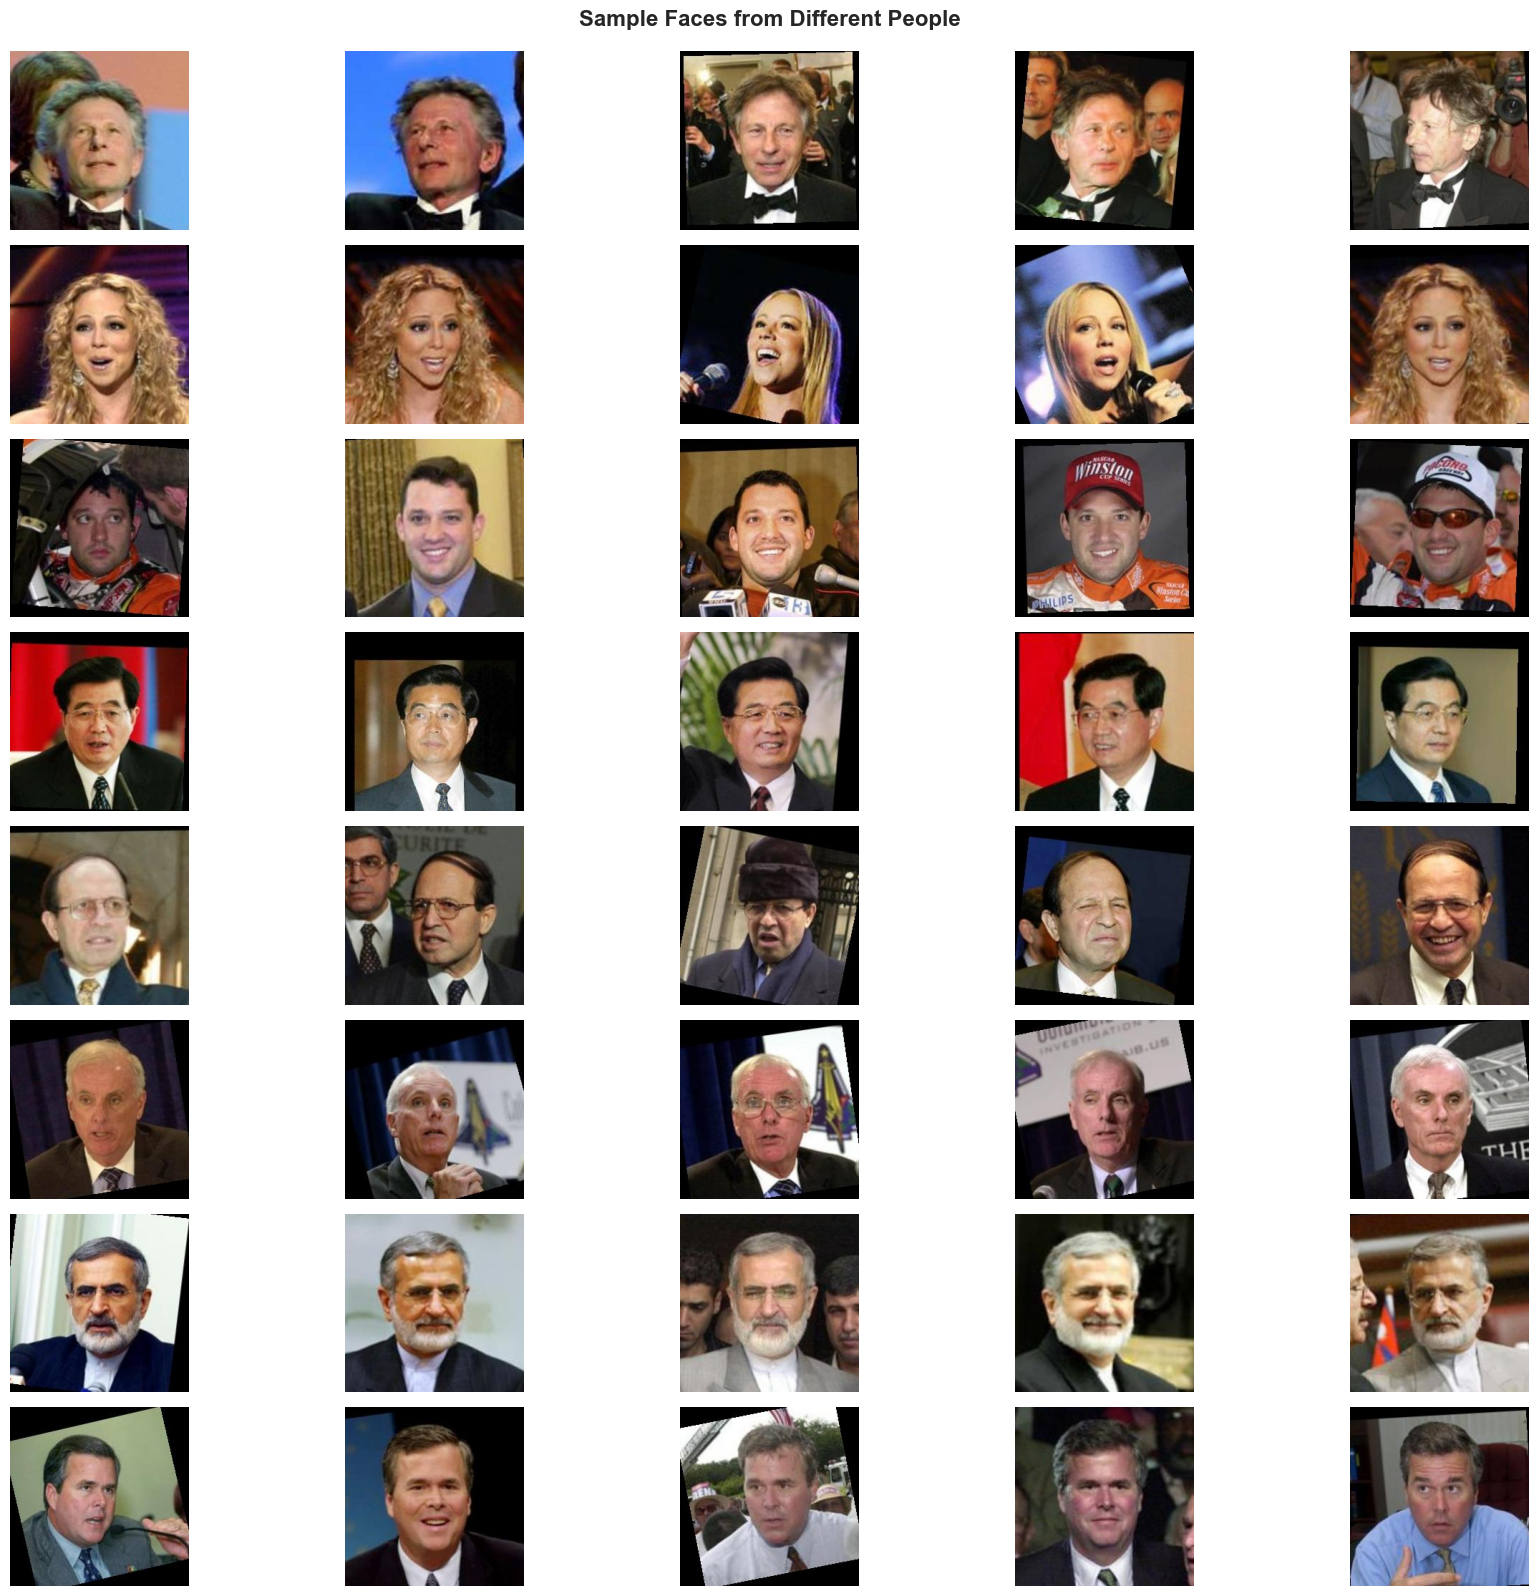

In [8]:
def load_sample_faces(data_dir, n_people=8, n_images_per_person=4):
    people_with_enough_images = [(name, count) for name, count in person_counts.items() if count >= n_images_per_person]
    sampled_people = np.random.choice([p[0] for p in people_with_enough_images], min(n_people, len(people_with_enough_images)), replace=False)

    samples = {}
    for person in sampled_people:
        person_path = os.path.join(data_dir, person)
        images = [f for f in os.listdir(person_path) if f.endswith(('.jpg', '.png'))]
        sampled_images = np.random.choice(images, min(n_images_per_person, len(images)), replace=False)

        samples[person] = []
        for img_name in sampled_images:
            img_path = os.path.join(person_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            samples[person].append(img)
    return samples

print("Loading sample faces...")
sample_faces = load_sample_faces(DATA_DIR, n_people=8, n_images_per_person=5)

n_people = len(sample_faces)
n_images = 5
fig, axes = plt.subplots(n_people, n_images, figsize=(18, 16))
fig.suptitle('Sample Faces from Different People', fontsize=16, fontweight='bold', y=0.995)

for i, (person, images) in enumerate(sample_faces.items()):
    for j, img in enumerate(images):
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            name_display = person.replace('_', ' ')[:25]
            axes[i, j].set_ylabel(name_display, fontsize=10, fontweight='bold', rotation=0, ha='right', va='center')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'sample_faces.png', dpi=300, bbox_inches='tight')
plt.show()


## Image Properties Analysis

In [10]:
def analyze_image_properties(data_dir, n_samples=500):
    properties = {
        'widths': [],
        'heights': [],
        'aspect_ratios': [],
        'brightness': [],
        'contrast': []
    }

    all_images = []
    for person in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person)
        if os.path.isdir(person_path):
            images = [os.path.join(person_path, f) for f in os.listdir(person_path) if f.endswith(('.jpg', '.png'))]
            all_images.extend(images)

    sampled_paths = np.random.choice(all_images, min(n_samples, len(all_images)), replace=False)

    for img_path in sampled_paths:
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        h, w = img.shape[:2]
        properties['widths'].append(w)
        properties['heights'].append(h)
        properties['aspect_ratios'].append(w / h)
        properties['brightness'].append(np.mean(gray))
        properties['contrast'].append(np.std(gray))

    return properties

properties = analyze_image_properties(DATA_DIR, n_samples=1000)

print("\n=== IMAGE PROPERTIES STATISTICS ===")
print("Image dimensions:")
print(f"  Width  - Mean: {np.mean(properties['widths']):.1f}, Std: {np.std(properties['widths']):.1f}")
print(f"  Height - Mean: {np.mean(properties['heights']):.1f}, Std: {np.std(properties['heights']):.1f}")
print(f"\nAspect ratio: {np.mean(properties['aspect_ratios']):.3f} ± {np.std(properties['aspect_ratios']):.3f}")
print(f"\nBrightness: {np.mean(properties['brightness']):.2f} ± {np.std(properties['brightness']):.2f}")
print(f"Contrast:   {np.mean(properties['contrast']):.2f} ± {np.std(properties['contrast']):.2f}")



=== IMAGE PROPERTIES STATISTICS ===
Image dimensions:
  Width  - Mean: 250.0, Std: 0.0
  Height - Mean: 250.0, Std: 0.0

Aspect ratio: 1.000 ± 0.000

Brightness: 95.20 ± 27.68
Contrast:   63.78 ± 11.42


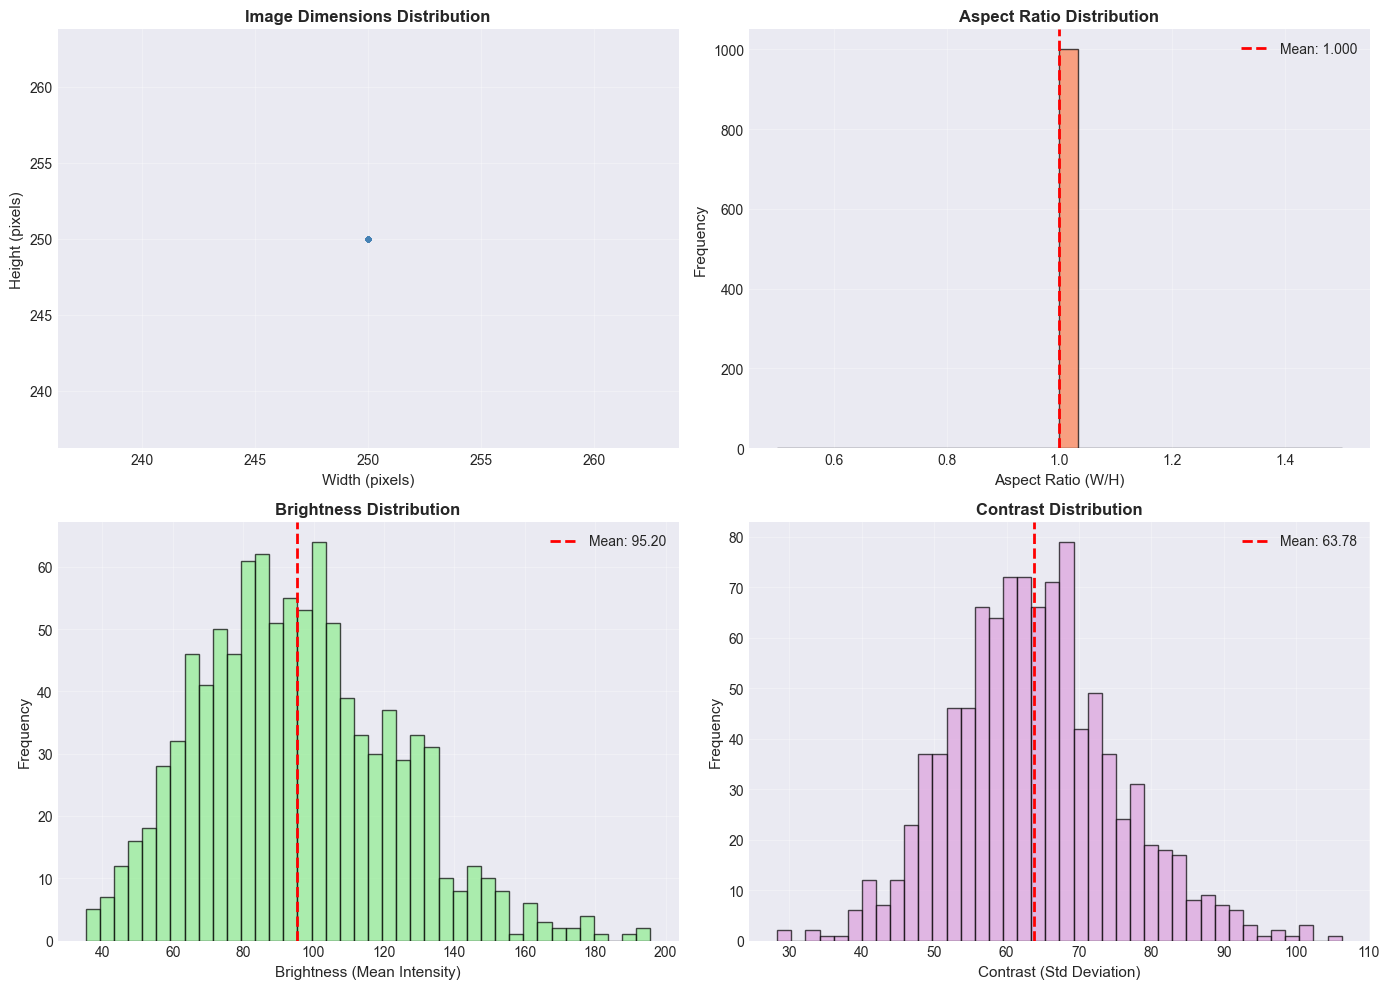

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].scatter(properties['widths'], properties['heights'], alpha=0.5, s=10, color='steelblue')
axes[0,0].set_xlabel('Width (pixels)', fontsize=11)
axes[0,0].set_ylabel('Height (pixels)', fontsize=11)
axes[0,0].set_title('Image Dimensions Distribution', fontsize=12, fontweight='bold')
axes[0,0].grid(alpha=0.3)

axes[0,1].hist(properties['aspect_ratios'], bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[0,1].axvline(np.mean(properties['aspect_ratios']), color='red', linestyle='--', linewidth=2,
                  label=f"Mean: {np.mean(properties['aspect_ratios']):.3f}")
axes[0,1].set_xlabel('Aspect Ratio (W/H)', fontsize=11)
axes[0,1].set_ylabel('Frequency', fontsize=11)
axes[0,1].set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

axes[1,0].hist(properties['brightness'], bins=40, color='lightgreen', alpha=0.7, edgecolor='black')
axes[1,0].axvline(np.mean(properties['brightness']), color='red', linestyle='--', linewidth=2,
                  label=f"Mean: {np.mean(properties['brightness']):.2f}")
axes[1,0].set_xlabel('Brightness (Mean Intensity)', fontsize=11)
axes[1,0].set_ylabel('Frequency', fontsize=11)
axes[1,0].set_title('Brightness Distribution', fontsize=12, fontweight='bold')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

axes[1,1].hist(properties['contrast'], bins=40, color='plum', alpha=0.7, edgecolor='black')
axes[1,1].axvline(np.mean(properties['contrast']), color='red', linestyle='--', linewidth=2,
                  label=f"Mean: {np.mean(properties['contrast']):.2f}")
axes[1,1].set_xlabel('Contrast (Std Deviation)', fontsize=11)
axes[1,1].set_ylabel('Frequency', fontsize=11)
axes[1,1].set_title('Contrast Distribution', fontsize=12, fontweight='bold')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'image_properties.png', dpi=300, bbox_inches='tight')
plt.show()

## Face Detection Quality Check

Checking face detection quality...

=== FACE DETECTION RESULTS ===
Images with 0 faces detected: 0
Images with 1 face detected: 8
Images with 2+ faces detected: 4

Detection rate: 100.0%


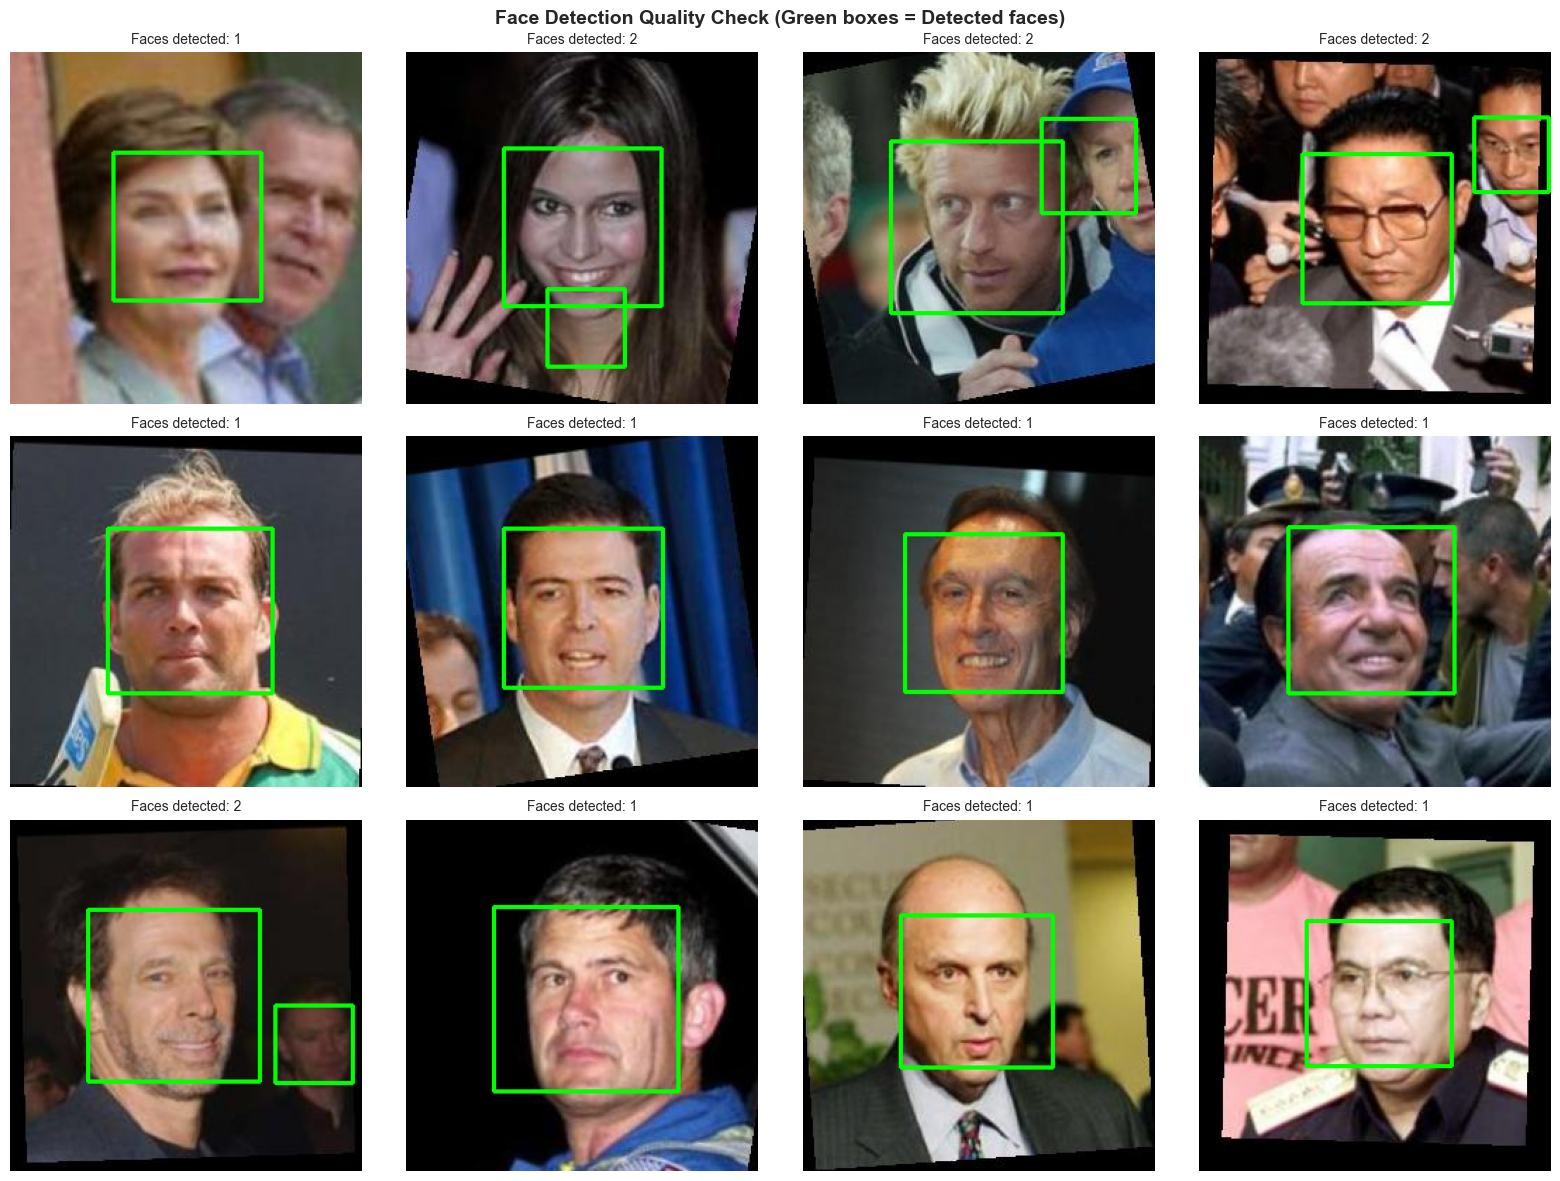

In [17]:
def check_face_detection(data_dir, n_samples=20):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    all_images = []
    for person in os.listdir(data_dir):
        person_path = os.path.join(data_dir, person)
        if os.path.isdir(person_path):
            images = [os.path.join(person_path, f) for f in os.listdir(person_path) if f.endswith(('.jpg', '.png'))]
            all_images.extend(images)

    sampled_paths = np.random.choice(all_images, min(n_samples, len(all_images)), replace=False)

    detection_results = []
    sample_images_with_boxes = []

    for img_path in sampled_paths:
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30,30))
        detection_results.append(len(faces))

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for (x, y, w, h) in faces:
            cv2.rectangle(img_rgb, (x,y), (x+w, y+h), (0,255,0), 2)
        sample_images_with_boxes.append(img_rgb)

    return detection_results, sample_images_with_boxes

print("Checking face detection quality...")
detection_results, sample_images = check_face_detection(DATA_DIR, n_samples=12)

print(f"\n=== FACE DETECTION RESULTS ===")
print(f"Images with 0 faces detected: {detection_results.count(0)}")
print(f"Images with 1 face detected: {detection_results.count(1)}")
print(f"Images with 2+ faces detected: {sum(1 for x in detection_results if x > 1)}")
print(f"\nDetection rate: {(len(detection_results) - detection_results.count(0)) / len(detection_results) * 100:.1f}%")

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Face Detection Quality Check (Green boxes = Detected faces)', fontsize=14, fontweight='bold')

for i, (ax, img, n_faces) in enumerate(zip(axes.flat, sample_images, detection_results)):
    ax.imshow(img)
    ax.set_title(f'Faces detected: {n_faces}', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'face_detection_check.png', dpi=300, bbox_inches='tight')
plt.show()

## Summary

In [16]:
summary = {
    'Dataset': 'LFW (lfw-deepfunneled)',
    'Total Images': total_images,
    'Total Identities': len(person_counts),
    'Avg Images per Person': f"{total_images/len(person_counts):.2f}",
    'Median Images per Person': f"{np.median(list(person_counts.values())):.0f}",
    'Max Images (One Person)': max(person_counts.values()),
    'People with 1 Image': counts_distribution[1],
    'People with 10+ Images': sum(1 for c in person_counts.values() if c >= 10),
    'Typical Image Size': f"{int(np.mean(properties['widths']))}×{int(np.mean(properties['heights']))} px",
    'Color Mode': 'RGB'
}

print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
for key, value in summary.items():
    print(f"{key:30s}: {value}")
print("="*60)



DATASET SUMMARY
Dataset                       : LFW (lfw-deepfunneled)
Total Images                  : 13233
Total Identities              : 5749
Avg Images per Person         : 2.30
Median Images per Person      : 1
Max Images (One Person)       : 530
People with 1 Image           : 4069
People with 10+ Images        : 158
Typical Image Size            : 250×250 px
Color Mode                    : RGB
